In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import networkx as nx
np.set_printoptions(suppress=True)

random.seed(9)
np.random.seed(9)
torch.manual_seed(9)
torch.cuda.manual_seed(9)

# Toy scenario

In [2]:
from causememaybe.toy import DiscreteToyProcess
from causememaybe.toy.discrete import beta_0_func, beta_1_func
from causememaybe.toy.visualise import plot_dataset, plot_treatment

n_samples = 5000
noise = 0.4
random_state = 9

In [3]:
dgp = DiscreteToyProcess(
                            n_samples=n_samples,
                            noise=noise,
                            random_state=random_state,
                            overlap="random",
                           )

Suppose we have a dataset. Where every patient's continious features are generated according to sklearn's [*make_moons*](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset. The classification label generated from this dataset is treated as a latent (unobserved) binary factor in our case denoted as $G \in \{0, 1\}$ - the idea is that it will confound our results. We plot this dataset below. 

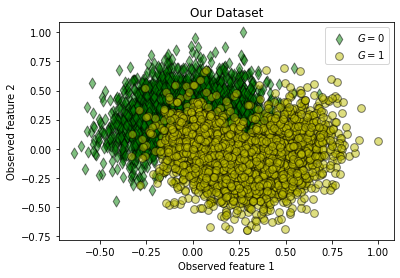

In [4]:
fig, ax = plot_dataset(dgp)

In our case we have a "subject" with continious features $X \in \mathcal{X}$, and unobserved categorical feature $G \in \{0, 1\}$. A subject could be a patient in the medical experiment or observational data, or an app user on facebook's platform.

### Treatment Assignment

#### Random Controlled Trial

Next we need to know what sort of treatment assignment we have in our data. If we are working with a randomized controlled trial (RCT), we know our treatment assignemnt $A$ will be random, and the propensity score will be 0.5 independent of the subjects covariates $X$. 

$
A \sim \text{Bernouli}(0.5)
$

we have the following plot that where marker shape shows latent variable value and color shows treatment assignment in the figure on the left. The figure on the right illiustrates how concentrated the propensity score is for both treated and control.

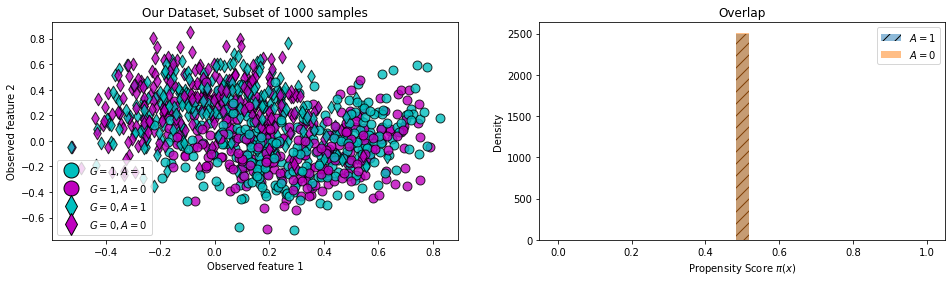

In [5]:
fig, axes = plot_treatment(dgp)

#### Observational Dataset

Now what is propensity score? A propensity score $\pi(x)$ is the probability of a unit (e.g., person, classroom, school) being assigned to a particular treatment given a set of observed covariates, namely:

$
\pi(x)= \mathbb{P}_\theta (A = 1 | X = x)
$

In essence, $\pi$ is the treatment assignment mechanism. In our case, we assume that in our observational dataset doctors had some partial knowledge about the underlying features $X$ and $G$ of the patients, and were able to some extend group them. We model it as a linear relationship between the patient's observed features $X$ and the log-odds (also called logit) of the $G=1$, which is a linear logistic regression $\text{sigmoid}(\beta_0 + \beta_1 x_1 + \beta_2 x_2)$. $\beta_0$ is set to have approximately 0.5 proportion of treated. $(\beta_1, \beta_2) = (1.18 \gamma, -1.76 \gamma)$, where $\gamma \in \{0.5, 1, 4 \}$ for strong, moderate and weak overlap. The higher is the overlap, the better are the doctors in determining the unobserved confounder $G$.

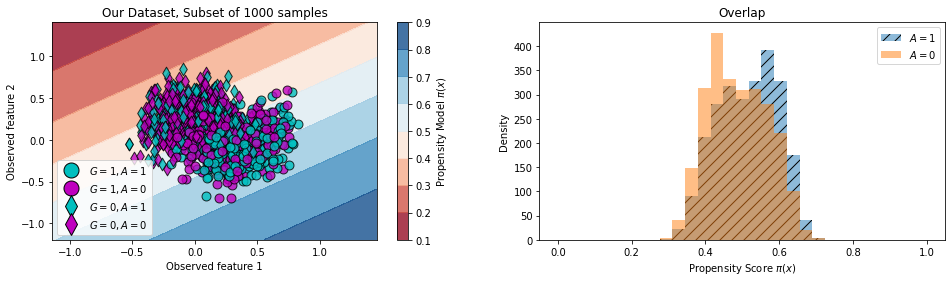

In [255]:
dgp_strong_overlap = DiscreteToyProcess(
                            n_samples=n_samples, 
                            noise=noise, 
                            random_state=random_state, 
                            overlap="strong",
                           )
fig, axes = plot_treatment(dgp_strong_overlap)

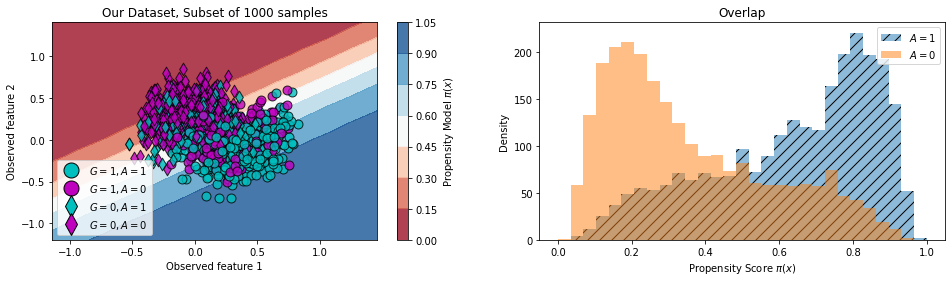

In [256]:
dgp_moderate_overlap = DiscreteToyProcess(
                            n_samples=n_samples, 
                            noise=noise, 
                            random_state=random_state, 
                            overlap="moderate",
                           )
fig, axes = plot_treatment(dgp_moderate_overlap)

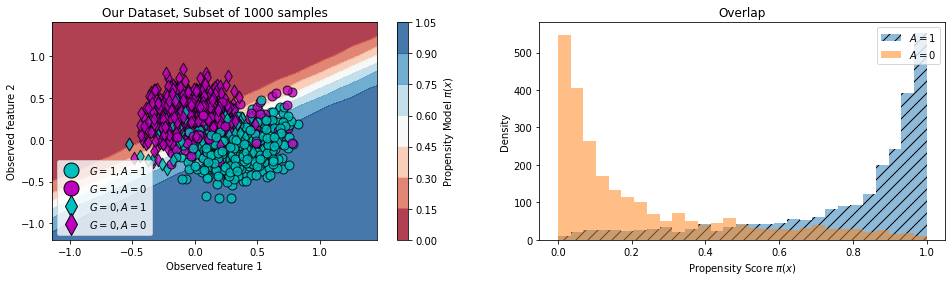

In [18]:
dgp_weak_overlap = DiscreteToyProcess(
                            n_samples=n_samples, 
                            noise=noise, 
                            random_state=random_state, 
                            overlap="weak",
                           )
fig, axes = plot_treatment(dgp_weak_overlap)

Later, we will cover the significance of overlap.

$A \in \{0, 1\}$ denotes a treatment variable, in this case we have only two treatment options: $A=0$ for no treatment, or control; and $A=1$ to indicate that a subject has been assigned to a treatment (e.g. new feature in an app, or hemeotherapy for a patient). 

### Binary outcome variable

The outcome variable $Y \in \{0, 1 \}$, is the outcome that we have actually observed in the experiment for a particular subject. The observed outcome $Y$ takes on values of either of the two "potential outcomes" $Y_{A=1}$ or $Y_{A=0}$ which depends on the value that $A$ takes, $Y = AY_{A=1} + (1-A)Y_{A=0}$.

In this work we generate binary outcomes from a Beta-Bernouli model. 

$
Y_{A} \sim \text{Bernoili}( \min[\rho + 0.2G, 1]), \text{ where } \rho \sim \text{Beta}(\alpha_{A}, \beta_{B})
$

$\alpha_{A=0} = 2$ and $\alpha_{A=1} = 5$ are shape parameters $\alpha > 0$. And $\beta_{A}$ are functions of subject features.

$
\beta_{A=0} = \exp(0.7 - 0.3 X_1 + 0.8 X_2) \\
\beta_{A=1} = \exp(0.9 - 0.5 X_1 + 0.5 X_2)
$

Number of positive outcomes in A=0: 2477; and in A=1: 2554


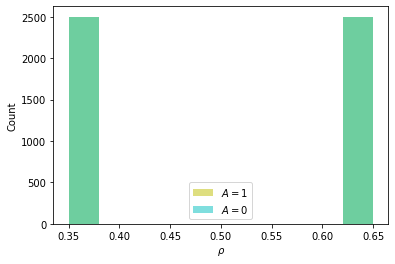

In [25]:
dgp = DiscreteToyProcess(
                            n_samples=n_samples,
                            noise=noise,
                            random_state=random_state,
                            overlap="weak",
                            coef=1
                           )

Y_1, rho_1, mu_1 = dgp.sample_outcomes("test")
Y_0, rho_0, mu_1 = dgp.sample_outcomes("control")
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(rho_1, label="$A = \\mathdefault{1}$", color="y", alpha=0.5);
ax.hist(rho_0, label="$A = \\mathdefault{0}$", color="c", alpha=0.5);
ax.legend();
ax.set_xlabel(r"$\rho$");
ax.set_ylabel("Count");
print("Number of positive outcomes in A=0: {}; and in A=1: {}".format(Y_0.sum(), Y_1.sum()))

### Data generation process recap

To recap we have the following: 

Observed features and latent binary factor generated from make moons function,

$
X, G \sim \text{sklearn make moons}
$

Treatment assignment for random controlled trial is:

$
A \sim \text{Bernouli}(0.5)
$

and for an observation study:

$
A \sim \text{Bernoili}(\pi(x)), \text{ where } \pi(x) = \text{Pr}(A=1|X=x)
$

Given the treatment assignment we generate factual survival time $Y_A$,

$
Y_{A} \sim \text{Bernoili}( \min[\rho + 0.2G, 1]), \text{ where } \rho \sim \text{Beta}(\alpha_{A}, \beta_{B})
$

which leads to observed outcome $Y$

$
Y = AY_{A=1} + (1-A)Y_{A=0}
$

### Causal graph

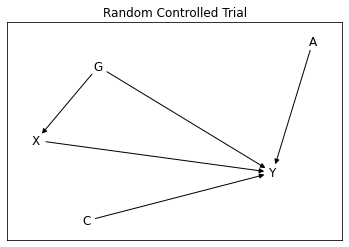

In [259]:
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('G', 'X'), ('G', 'Y'), ('C', 'Y'), ('X', 'Y'), ('A', 'Y')])
fig, ax = plt.subplots(figsize=(6,4));
nx.draw_networkx(G, arrows=True, node_color="white", ax=ax)
ax.set_title("Random Controlled Trial");

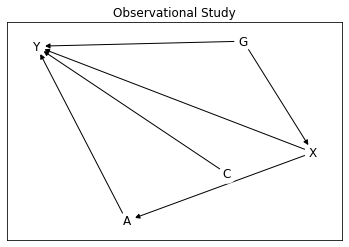

In [260]:
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('G', 'X'), ('G', 'Y'), ('C', 'Y'), ('X', 'Y'), ('A', 'Y'), ("X", "A")])
fig, ax = plt.subplots(figsize=(6,4));
nx.draw_networkx(G, arrows=True, node_color="white", ax=ax)
ax.set_title("Observational Study");

### Potential outcomes framework

The overall framework and notation we adopted above is referred to as _potential outcomes framework_ for modeling causal effects in observational and experimental studies. In our case we have a "subject" with continious features $X \in \mathcal{X}$, and unobserved categorical feature $G \in \{0, 1\}$. A subject could be a patient in the medical experiment or observational data, or an app user on facebook's platform. $A \in \{0, 1\}$ denotes a treatment variable, in this case we have only two treatment options: $A=0$ for no treatment, or control; and $A=1$ to indicate that a subject has been assigned to a treatment (e.g. new feature in an app, or hemeotherapy for a patient). The outcome variable $Y \in \{0, 1 \}$, is the outcome time that we have actually observed in the experiment for a particular subject. The observed outcome $Y$ takes on values of either of the two "potential outcomes" $Y_{A=1}$ or $Y_{A=0}$ which depends on the value that $A$ takes, hence $Y = AY_{A=1} + (1-A)Y_{A=0}$.

When working with observational data or data from a randomized control trials, we tipycally are given $N$ samples of the tuples $Z = (X, A, Y)$ (forgetting for a second that we may have some unobserved confounders $U$, in our case binary variable $G$). Samples $Z$ are drawn from some underlying probability distribution with paramters $\theta$

$
Z_1, ..., Z_n \sim \mathbb{P}_{\theta}
$

We may further breakdown $\theta$ into a collection a _nuissance_ paramters (paramters that are not of imediate interest but need to be accounted for):

$
\theta = \{ \mu_{A=1}, \mu_{A=0}, \pi, \eta \}
$

where $\mu_{A=1}(x) = \mathbb{E}_{\theta}[Y_{A=1}|X=x]$ and $\mu_{A=0}(x) = \mathbb{E}_{\theta}[Y_{A=0}|X=x]$ are conditional potential outcomes for a subject with features $x$. and $\pi$ is the treatment assignment mechanism,

$
\pi(x)= \mathbb{P}_\theta (A = 1 | X = x)
$

and $\eta(x) = \mathbb{P}_\theta (X=x)$. 

In the simulation above we have access to each of the steps of the data generative process, and we know that the treatment assignment is random.

Our goal is then to use causal inference techniques to infer the treatment effects function $\tau(X)$ of individual subjects based on their features using the samples $\{ Z_i \}^{N}_{i=1}$. The treatment effect function is defined as $\tau(X) = \mathbb{E}[Y_{A=1} - Y_{A=1} | X] = \mu_{A=1}(x) - \mu_{A=0}(x)$, known as Individual Treatment Effect (ITE). Our causal model $M$ maps a dataset $\{ Z_i \}^{N}_{i=1}$ to an estimate $\hat{\tau}(.)$ of ITE. The accuracy of the model is charaterised by the squarred-$L^2$ loss:

$
\epsilon_{PEHE} = || \hat{\tau}(X) - \tau(X) ||^{2}_\theta \approx \frac{1}{N} \sum^{N}_{n=1} || \hat{\tau}(X=x_n) - \tau(X=x_n) ||^{2}_\theta
$

also known as Precision of Estimating Heterogeneous Effects (PEHE), where $||f(X)||^{2}_\theta = \mathbb{E}_{\theta}[f^{2}(X)]$. 

Note that to estimate PEHE one has to have access to factual and counterfactual outcomes and their generative distribution, so that their expectations of the outcomes can be compared.

### Coming back to data

In [261]:
dgp.df.head(n=10)

,x0,x1,latent_binary_confounder,treatment_assignment,true_treatment_prob,y_test,y_control,mu_test,mu_control,rho_test,rho_control,observed
0,0.175632,0.651367,0,0,0.5,1,0,0.490187,0.242712,0.533770,0.214027,0.0
1,-0.331225,-0.264673,0,0,0.5,1,1,0.541240,0.282261,0.571860,0.545779,1.0
2,0.243493,-0.167557,1,1,0.5,1,0,0.599681,0.333038,0.903922,0.243055,1.0
3,-0.038084,0.503672,0,0,0.5,0,0,0.481941,0.236696,0.355416,0.099319,0.0
4,0.139760,0.193171,0,1,0.5,1,0,0.542871,0.283594,0.704115,0.020853,1.0
5,0.442344,0.065242,0,1,0.5,1,0,0.595600,0.329279,0.378543,0.078001,1.0
6,0.064051,0.095395,1,0,0.5,1,0,0.545608,0.285841,0.839710,0.362123,0.0
7,0.244254,-0.276760,1,1,0.5,1,1,0.612805,0.345361,0.956571,0.631192,1.0
8,0.277913,0.339293,0,0,0.5,1,1,0.541882,0.282785,0.854790,0.110042,1.0
9,0.321900,0.036512,0,1,0.5,1,0,0.584508,0.319231,0.275238,0.182744,1.0


We can see our continious features $X$ as `x0` and `x1`; latent confounder $G$ as `latent_binary_confounder`; treatment assignment indicator; conditional potential outcomes $\mu_{A=1}(x)$ and $\mu_{A=0}(x)$ denoted as `mu_test` and `mu_control`; and the corresponding sampled potential outcomes `y_test` and `y_control`, and the observed outcome `observed`.

In [262]:
print("% of treated subjects: {}".format(dgp.df.treatment_assignment.sum()/len(dgp.df)*100))

% of treated subjects: 49.8


In [263]:
rho_given_x_true = dgp.df.mu_test - dgp.df.mu_control
avg_rho_true = np.sum(rho_given_x_true) / len(dgp.df)
print("Average true Treatment Effect: {:.3f}".format(avg_rho_true))

Average true Treatment Effect: 0.259
